In [1]:
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.cs_vqe_tools as cs_tools
import utils.plotting_tools as plot
from utils.molecule_tools import get_molecule
from matplotlib import pyplot as plt
import json

file = 'molecule_data'
with open('data/'+file+'.json', 'r') as json_file:
    molecule_data = json.load(json_file)
        
species = list(molecule_data.keys())
species

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


['H2_3-21G_SINGLET',
 'H3+_STO-3G_SINGLET',
 'H3+_3-21G_SINGLET',
 'HeH+_3-21G_SINGLET',
 'HeH+_6-311G_SINGLET',
 'H2O_STO-3G_SINGLET',
 'BeH+_STO-3G_SINGLET',
 'LiH_STO-3G_SINGLET',
 'CH+_STO-3G_SINGLET',
 'FH_STO-3G_SINGLET',
 'B+_STO-3G_SINGLET']

In [2]:
anz_data = {}
for speciesname in species:
    print(speciesname)
    molecule    = get_molecule(speciesname, taper_num=0)
    num_qubits  = molecule['num_qubits']
    ham         = molecule['hamiltonian']
    uccsd       = molecule['uccsdansatz']
    terms_noncon = cs_tools.greedy_dfs(ham, 3, criterion='size')[-1]
    mol_circ = cs_circ.cs_vqe_circuit(hamiltonian=ham,
                                      terms_noncon=terms_noncon,
                                      num_qubits=num_qubits, 
                                      rot_A=True)
    anz_data[speciesname] = {'num_qubits':num_qubits, 
                             'num_terms':{'full':len(uccsd)},
                             'circdepth':{'full':mol_circ.full_uccsd(uccsd).depth()}}
    for num_sim_q in range(1, num_qubits+1):
        anz_data[speciesname]['num_terms'][num_sim_q] = len(mol_circ.project_anz_terms(uccsd, num_sim_q))
        anz_data[speciesname]['circdepth'][num_sim_q] = mol_circ.build_circuit(uccsd, num_sim_q).depth()


H2_3-21G_SINGLET


/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


H3+_STO-3G_SINGLET
H3+_3-21G_SINGLET
HeH+_3-21G_SINGLET
HeH+_6-311G_SINGLET
H2O_STO-3G_SINGLET
BeH+_STO-3G_SINGLET
LiH_STO-3G_SINGLET
CH+_STO-3G_SINGLET
FH_STO-3G_SINGLET
B+_STO-3G_SINGLET


In [5]:
anz_data

{'H2_3-21G_SINGLET': {'num_qubits': 8,
  'num_terms': {'full': 28, 1: 0, 2: 2, 3: 4, 4: 4, 5: 4, 6: 12, 7: 20, 8: 40},
  'circdepth': {'full': 604,
   1: 3,
   2: 29,
   3: 65,
   4: 65,
   5: 73,
   6: 257,
   7: 425,
   8: 937}},
 'H3+_STO-3G_SINGLET': {'num_qubits': 6,
  'num_terms': {'full': 16, 1: 0, 2: 2, 3: 4, 4: 6, 5: 8, 6: 24},
  'circdepth': {'full': 339, 1: 3, 2: 29, 3: 65, 4: 117, 5: 165, 6: 541}},
 'H3+_3-21G_SINGLET': {'num_qubits': 12,
  'num_terms': {'full': 44,
   1: 0,
   2: 2,
   3: 2,
   4: 2,
   5: 2,
   6: 12,
   7: 20,
   8: 20,
   9: 20,
   10: 28,
   11: 36,
   12: 64},
  'circdepth': {'full': 974,
   1: 3,
   2: 29,
   3: 33,
   4: 33,
   5: 41,
   6: 257,
   7: 425,
   8: 425,
   9: 441,
   10: 625,
   11: 793,
   12: 1769}},
 'HeH+_3-21G_SINGLET': {'num_qubits': 8,
  'num_terms': {'full': 36, 1: 1, 2: 1, 3: 4, 4: 6, 5: 6, 6: 18, 7: 28, 8: 48},
  'circdepth': {'full': 796,
   1: 11,
   2: 15,
   3: 64,
   4: 109,
   5: 129,
   6: 405,
   7: 665,
   8: 1261}},

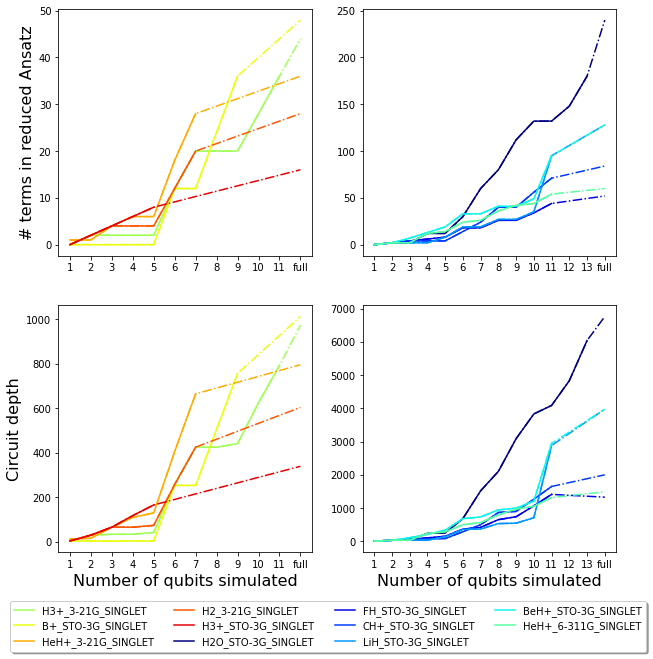

In [121]:
anz_data_sorted = sorted(anz_data, key=lambda x:anz_data[x]['num_qubits'])
anz_data_sorted.reverse()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))

for i, speciesname in enumerate(anz_data_sorted):
    c = plt.cm.jet(i/len(anz_data))
    if i <=5:
        index = 1
    else:
        index = 0
    
    data = anz_data[speciesname]
    X = list(range(1, data['num_qubits']))#+['full']
    X_full = X+['full']
    Y_anznm = [data['num_terms'][i] for i in X]
    Y_anznm_full = [data['num_terms'][i] for i in X_full]
    Y_depth = [data['circdepth'][i] for i in X]
    Y_depth_full = [data['circdepth'][i] for i in X_full]

    axes[(0, index)].plot(list(range(data['num_qubits']-1)), Y_anznm, label=speciesname, color=c)
    axes[(1, index)].plot(list(range(data['num_qubits']-1)), Y_depth, color=c)
    axes[(0, index)].plot(X_full, Y_anznm_full, color=c, ls='-.')
    axes[(1, index)].plot(X_full, Y_depth_full, color=c, ls='-.')
    #axes[(0, 1)].set_xticklabels(list(range(1, 14))+['full'])

for i in range(2):
    axes[(1,i)].set_xlabel('Number of qubits simulated',fontsize=16)
axes[(0,0)].set_ylabel('# terms in reduced Ansatz',fontsize=16)
axes[(1,0)].set_ylabel('Circuit depth',fontsize=16)

fig.legend(loc='lower center',bbox_to_anchor=(0.5, -0.02),
          fancybox=True, shadow=True, ncol=4)

In [122]:
fig.savefig('plots/reduced_ansatz_depth.png', dpi=300, bbox_inches='tight')

In [37]:
len(anz_data_sorted)

11